In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import warnings 
warnings.filterwarnings("ignore")

df = pd.read_csv('super_clena_crimes.csv')

## Tasa de crimen por vecindario

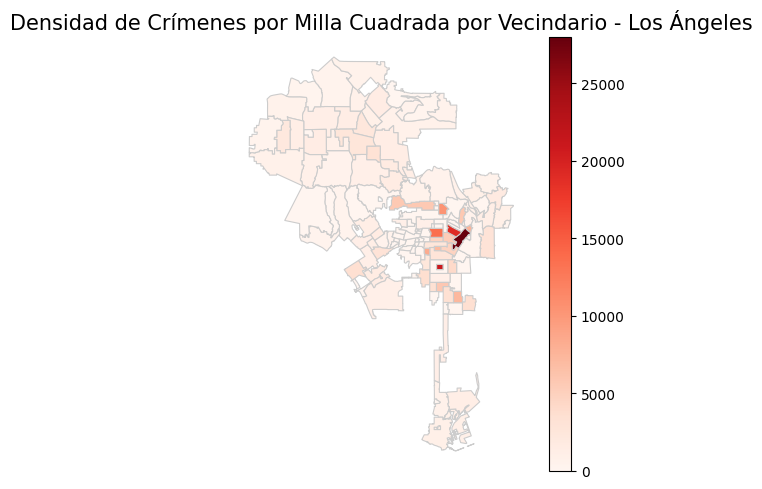

In [25]:
vecindarios = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/eva_pereira_lahub_BA_24d4f6a092ee4506/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

# Proyectar a un sistema de coordenadas adecuado para cálculo de áreas
vecindarios = vecindarios.to_crs(epsg=3857)

# Calcular el área en metros cuadrados
vecindarios["area_m2"] = vecindarios["geometry"].area

# Convertir el área a millas cuadradas (1 milla cuadrada = 2.59e+6 m²)
vecindarios["area_millas2"] = vecindarios["area_m2"] / 2.59e+6

# Volver a proyectar a WGS84 para visualización
vecindarios = vecindarios.to_crs(epsg=4326)


delitos_por_vecindario = df.groupby("Vecindario").size().reset_index(name="total_delitos")


# Unir los datos
vecindarios = vecindarios.merge(delitos_por_vecindario, left_on="name", right_on="Vecindario", how="left")

# Rellenar valores nulos con 0
vecindarios["total_delitos"] = vecindarios["total_delitos"].fillna(0)
vecindarios["delitos_por_milla2"] = vecindarios["total_delitos"] / vecindarios["area_millas2"]

# Crear el mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
vecindarios.plot(column='delitos_por_milla2', 
                 cmap='Reds', 
                 linewidth=0.8, 
                 edgecolor='0.8', 
                 legend=True, 
                 ax=ax)

ax.set_title('Densidad de Crímenes por Milla Cuadrada por Vecindario - Los Ángeles', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()


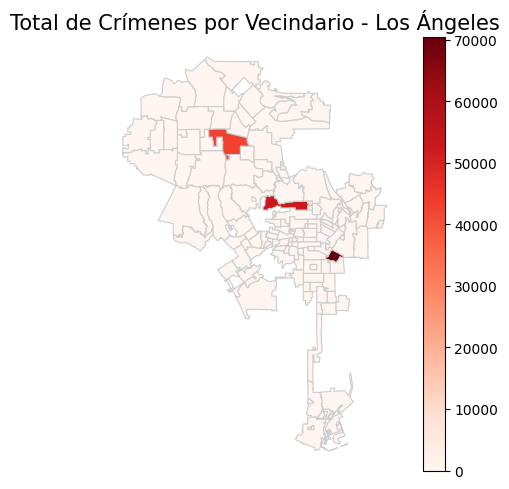

In [23]:
# Crear el mapa de calor (ahora por total de delitos, no por milla cuadrada)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
vecindarios.plot(column='total_delitos', 
                 cmap='Reds', 
                 linewidth=0.8, 
                 edgecolor='0.8', 
                 legend=True, 
                 ax=ax)

ax.set_title('Total de Crímenes por Vecindario - Los Ángeles', fontsize=15)
ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Agrupar por vecindario y tipo de delito
delitos_vecindario = df.groupby(['Vecindario', 'Tipo_Delito']).size().unstack(fill_value=0)
delitos_vecindario

Tipo_Delito,Ambiguo,No violento,Violento
Vecindario,,,
Adams-Normandie,277,838,2693
Arleta,385,877,2719
Arlington Heights,433,953,3859
Atwater Village,198,423,1881
Baldwin Hills/Crenshaw,1378,1517,7118
...,...,...,...
Westwood,571,1081,5130
Wilmington,765,2649,9700
Windsor Square,121,262,1185


In [4]:
# % de crimen por vecindario
crime_by_neighborhood = (df.groupby('Vecindario').size())/len(df)

# Mostrar los resultados
print(crime_by_neighborhood)

Vecindario
Adams-Normandie           0.003780
Arleta                    0.003952
Arlington Heights         0.005207
Atwater Village           0.002484
Baldwin Hills/Crenshaw    0.009940
                            ...   
Westwood                  0.006733
Wilmington                0.013019
Windsor Square            0.001557
Winnetka                  0.008976
Woodland Hills            0.014507
Length: 114, dtype: float64


## Tipos de crimen (violentos vs. no violentos)

In [5]:
# Crear una columna de año y mes en formato YYYY-MM
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df['AñoMes'] = df['DATE OCC'].dt.to_period('M')

# Agrupar por año-mes y tipo de delito
frecuencia_mensual = df.groupby(['AñoMes', 'Tipo_Delito']).size().unstack(fill_value=0)

# (Opcional) convertir el índice a datetime para graficar si es necesario
frecuencia_mensual.index = frecuencia_mensual.index.to_timestamp()



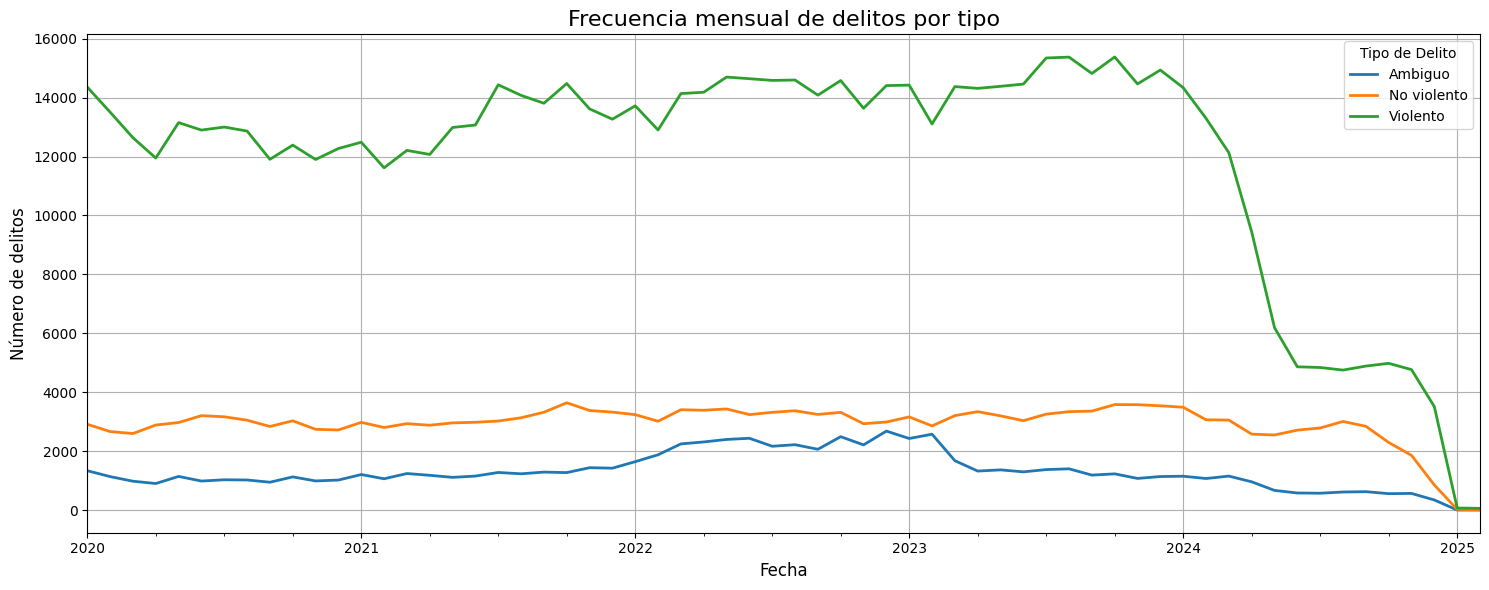

In [12]:
frecuencia_mensual.plot(figsize=(15, 6), linewidth=2)

# Estética del gráfico
plt.title("Frecuencia mensual de delitos por tipo", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de delitos", fontsize=12)
plt.legend(title="Tipo de Delito")
plt.grid(True)
plt.tight_layout()

plt.show()

In [7]:
# Calcular maximo o minimo Violento o No Violento
porcentaje_vecindario = delitos_vecindario.div(delitos_vecindario.sum(axis=1), axis=0) * 100
porcentaje_vecindario['Violento'].idxmax()

'Griffith Park'

In [13]:
porcentaje_vecindario

Tipo_Delito,Ambiguo,No violento,Violento
Vecindario,,,
Adams-Normandie,7.274160,22.006303,70.719538
Arleta,9.670937,22.029641,68.299422
Arlington Heights,8.255481,18.169685,73.574833
Atwater Village,7.913669,16.906475,75.179856
Baldwin Hills/Crenshaw,13.762109,15.150305,71.087586
...,...,...,...
Westwood,8.419345,15.939251,75.641404
Wilmington,5.833460,20.199786,73.966753
Windsor Square,7.716837,16.709184,75.573980


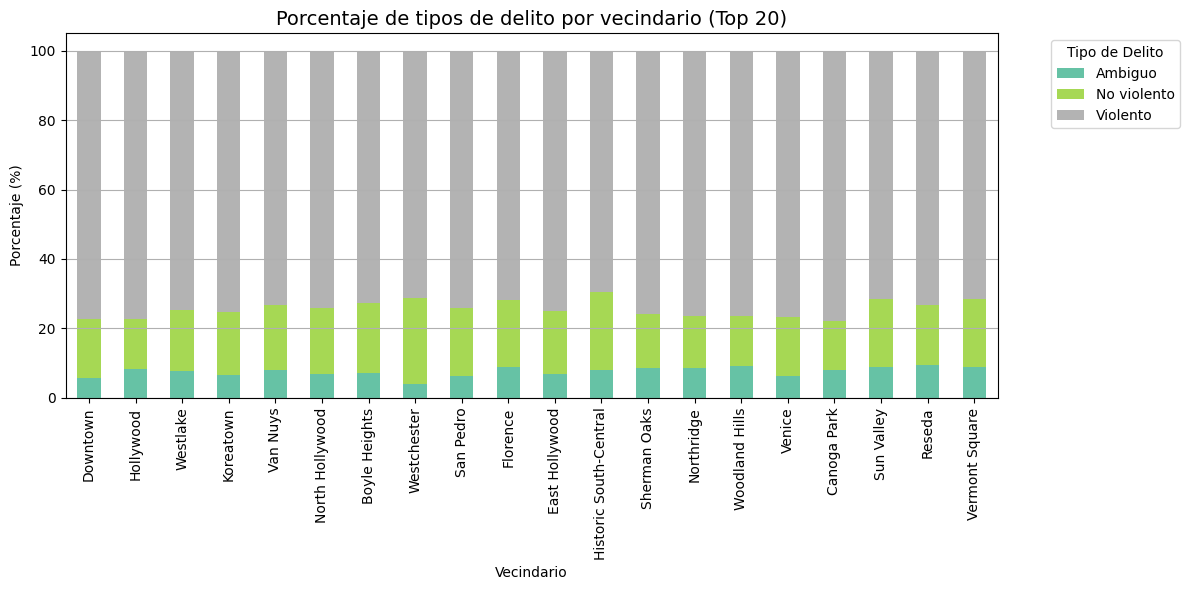

In [9]:
# Seleccionar los vecindarios más frecuentes (opcional, para no saturar el gráfico)
top_vecindarios = df['Vecindario'].value_counts().nlargest(20).index
top_data = porcentaje_vecindario.loc[top_vecindarios]

# Graficar
top_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

# Estética
plt.title('Porcentaje de tipos de delito por vecindario (Top 20)', fontsize=14)
plt.xlabel('Vecindario')
plt.ylabel('Porcentaje (%)')
plt.legend(title='Tipo de Delito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')

plt.show()

## Frecuencia de tipos de crimen (por año)

In [18]:
# Agrupar por año y tipo de delito
frecuencia_anual = df.groupby(['Año', 'Tipo_Delito']).size().unstack(fill_value=0)

# Mostrar tabla
print(frecuencia_anual)


Tipo_Delito  Ambiguo  No violento  Violento
Año                                        
2020           12607        34779    152823
2021           14880        37349    158112
2022           26744        38889    170160
2023           18067        39446    175368
2024            8853        31088     87993
2025               2           36       128


In [15]:
# Contar cada tipo de delito y mostrar el total
tipos_delito = df['Tipo_Delito'].value_counts()

# Mostrar tabla
print(tipos_delito)
#Total

Tipo_Delito
Violento       744584
No violento    181587
Ambiguo         81153
Name: count, dtype: int64
